### Collaboration's notice


1. Improvements compared with V0.1:
   - Break the function ``egm_factory`` into two functions ``optimal_c`` and ``K``.
   - Convert it into ``MyST-md`` format by ``jupytext``.
   - Adjust the coefficient of $P$, shocks and of the grid.
   - Converging time is **much shorter**.
   - Add assumption testings for general cases of $\beta R$.
     - The assumption testing is on the money!
   - Change the loop structure.
   - Change the expression for $R_t$, $\beta$ and $Y$.

2. Fault:
   - $\beta$ is not stochastic/state dependent.

3. Solution:
   - Simulate z_vec and P_z from the AR(1) $Z_t$ by using the function ``rouwenhorst`` in the ``QuantEcon.py``.
   - Set up appropriate expressions of stochastic processes, $\beta_t(z_t, ε_t)$, $R_t(z_t, ζ_t)$ and $Y_t(z_t, η_t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64, int64
from quantecon.optimize.root_finding import brentq
from scipy.linalg import eig, eigvals

%matplotlib inline

In [2]:
ifp_data = [
    ('γ', float64),              # Utility parameter
#     ('β', float64),
    ('P', float64[:, :]),        # Transition probs for z_t
#     ('z_vec', float64[:]),       # Shock scale parameters for R_t, Y_t     
    ('a_grid', float64[:]),      # Grid over asset values (array)
    ('s_grid', float64[:]),
    
    ('ε_draws', float64[:]),
    ('η_draws', float64[:]),     # Draws of innovation η for MC (array)
    ('ζ_draws', float64[:]),     # Draws of innovation ζ for MC (array)
    
    ('N', int64),
    ('n', int64),
    
    ('β_scale', float64),
    ('R_scale', float64),
    ('y_scale', float64),
    ('k', int64),
    
    ('β_loc', float64),
    ('R_loc', float64),
    ('y_loc', float64),
    
    ('β_a', float64),            # scale parameter for β_t inside
    ('β_b', float64),            # additive parameter for β_t inside
    ('R_a', float64),            # scale parameter for R_t inside
    ('R_b', float64),            # additive parameter for R_t inside
    ('y_a', float64),            # scale parameter for Y_t inside
    ('y_b', float64),            # additive parameter for Y_t side
    
]

In [3]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation 
    problem. 
    """
    def __init__(self,
                 γ=1.5,
                 P=np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 scale_out= np.array((0, 1, 1)),
                 loc_out=np.array((0.96, 0, 0)),
                 scale_a= np.array((0.0, 0.2, 0.5)),
                 loc_b= np.array((0.0, 0.0, 2)),
                 shock_draw_size=35,
                 grid_max=10,
                 grid_size=20,
                 seed=1234):
        
        np.random.seed(seed)  # arbitrary seed

        self.γ = γ
        self.P = P 
        
        self.ε_draws = np.random.randn(shock_draw_size)
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        
        self.n = len(P)
        self.N = len(self.ε_draws) * len(self.η_draws) * len(self.ζ_draws)
        
        self.β_scale, self.R_scale, self.y_scale = scale_out[0], scale_out[1], scale_out[2]
        self.β_loc, self.R_loc, self.y_loc = loc_out[0], loc_out[1], loc_out[2]
        
        self.β_a, self.R_a, self.y_a = scale_a[0], scale_a[1], scale_a[2]
        self.β_b, self.R_b, self.y_b = loc_b[0], loc_b[1], loc_b[2]
        
        self.s_grid = np.linspace(0, grid_max, grid_size) # 2 remove a_grid
        self.k = len(self.s_grid)
        
    # Marginal utility    
    def u_prime(self, c):
        return c ** (-self.γ)
    
    # Inverse utility
    def u_prime_inv(self, du):
        return du ** (-1 / self.γ)
    
    def β(self, z, ϵ):
        return self.β_scale * np.exp(z * self.β_b + self.β_a * ϵ) + self.β_loc
    
    def R(self, z, ζ):
        return self.R_scale * np.exp(z * self.R_b + self.R_a * ζ) + self.R_loc
    
    def Y(self, z, η):
        return self.y_scale * np.exp(z * self.y_b + self.y_a * η) + self.y_loc

## Implement the endogenous grid method

In [4]:
@jit(nopython=True)
def K(a_array, c_array, ifp):
    
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    s_grid = ifp.s_grid # tick
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    n, N = ifp.n, ifp.N
    

        
    c = lambda a, z: interp(a_array[:, z], c_array[:, z], a)
    
    
    c_new = np.empty_like(c_array)
    a_new = np.empty_like(a_array)
    for z in range(n):
        for i, s in enumerate(s_grid):
            Ez = 0.0
            for z_hat in prange(n):
                for ϵ in ε_draws:
                    for ζ in ζ_draws:
                        for η in η_draws:
                            β_hat = β(z_hat, ϵ)
                            R_hat = R(z_hat, ζ)
                            Y_hat = Y(z_hat, η)
                            Ez += β_hat * R_hat * u_prime(c(R_hat * s + Y_hat, z_hat)) * P[z, z_hat]
            Ez = Ez / N
            c_new[i, z] = u_prime_inv(Ez)
            
        a_new[:, z] = c_new[:, z] + s_grid
#         c_new[:, z] = interp(a_new[:,z], c_new[:, z], a_array)
        
#     for z in range(n):
#         a_new[:, z] = c_new[:, z] + s_grid
#         c_new[:, z] = interp(a_new[:,z], c_new[:, z], a_array)

    c_new[0, :] = 0
    a_new[0, :] = 0
        
    return a_new, c_new

In [5]:
def solve_model(ifp,
                K,
                tol=1e-3,
                max_iter=1e3,
                verbose=True,
                print_skip=25):

    """
    Solves for the optimal policy using operator K

    * ifp is an instance of ConsumerProblem
    * K is an operator that updates consumption policy
    """

    # Initial guess of a and c
    
    c = np.empty((ifp.k, ifp.n))
    for z in range(ifp.n):
        c[:, z] = ifp.s_grid
    a = np.copy(c)

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, c_new = K(a, c, ifp)

        error = np.max(np.abs(c - c_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        a[:, :], c[:, :] = a_new, c_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return a, c

In [6]:
ifp = IFP()

In [7]:
%%time
a, c = solve_model(ifp, K, print_skip=5)

Error at iteration 5 is 0.7797458317347328.
Error at iteration 10 is 0.26139235538935957.
Error at iteration 15 is 0.11809692699064289.
Error at iteration 20 is 0.06452436509624127.
Error at iteration 25 is 0.040089544934331034.
Error at iteration 30 is 0.02710872755345628.
Error at iteration 35 is 0.019396894632569772.
Error at iteration 40 is 0.014438030041203476.
Error at iteration 45 is 0.011059387829143397.
Error at iteration 50 is 0.008656980458660257.
Error at iteration 55 is 0.006891321083666302.
Error at iteration 60 is 0.005558509962087843.
Error at iteration 65 is 0.004531031678532749.
Error at iteration 70 is 0.0037249055186001634.
Error at iteration 75 is 0.0030835609067740855.
Error at iteration 80 is 0.0025672938787297817.
Error at iteration 85 is 0.0021475985627898986.
Error at iteration 90 is 0.0018035891219656541.
Error at iteration 95 is 0.0015197120385215257.
Error at iteration 100 is 0.0012840764192691978.
Error at iteration 105 is 0.0010875171694082475.

Converged

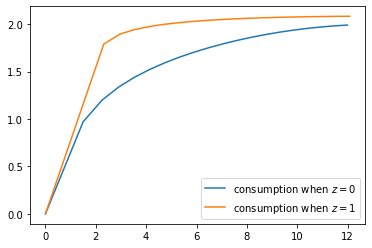

In [8]:
fig, ax = plt.subplots()

for z in range(len(ifp.P)):
    plt.plot(a[:, z], c[:, z], label=f"consumption when $z = {z}$")

plt.legend()
plt.show()

## Testing the assumptions

In [9]:
# @njit
def G_βR(ifp):
    
    s_grid = ifp.s_grid # tick
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    n= ifp.n
    
    L = np.empty_like(P)
    for z in range(n):
        for z_hat in prange(n):
            Ez = 0.0
            for ϵ in ε_draws:
                for ζ in ζ_draws:
                        β_hat = β(z_hat, ϵ)
                        R_hat = R(z_hat, ζ)
                        Ez += β_hat * R_hat
            Ez = Ez / (len(ε_draws) * len(ζ_draws))
            L[z, z_hat] = Ez * P[z, z_hat]
    print(L)
    
    
    return np.max(abs(eigvals(L)))

In [10]:
G_βR(ifp)

[[0.89261695 0.09917966]
 [0.09917966 0.89261695]]


0.9917966139921779

### Collaboration's notice


1. Improvements compared with V0.1:
   - Break the function ``egm_factory`` into two functions ``optimal_c`` and ``K``.
   - Convert it into ``MyST-md`` format by ``jupytext``.
   - Adjust the coefficient of $P$ and $\sigma$_vec and $\mu$-vec.
   - Converging time is **much shorter**.
   - Add assumption testings.
     - The assumption testing is on the money.
   - Change the loop structure.

2. Fault:
   - $\beta$ is not stochastic/state dependent.

3. Solution:
   - Simulate z_vec and P_z from the AR(1) $Z_t$ by using the function ``rouwenhorst`` in the ``QuantEcon.py``.
   - Set up appropriate expressions of stochastic processes, $\beta_t(z_t, ε_t)$, $R_t(z_t, ζ_t)$ and $Y_t(z_t, η_t)$.

In [272]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64
from quantecon.optimize.root_finding import brentq
from scipy.linalg import eig, eigvals

%matplotlib inline

In [450]:
ifp_data = [
    ('γ', float64),              # Utility parameter
#     ('β', float64),
    ('P', float64[:, :]),        # Transition probs for z_t
    ('z_vec', float64[:]),       # Shock scale parameters for R_t, Y_t     
    ('a_grid', float64[:]),      # Grid over asset values (array)
    ('s_grid', float64[:]),
    
    ('ε_draws', float64[:]),
    ('η_draws', float64[:]),     # Draws of innovation η for MC (array)
    ('ζ_draws', float64[:]),     # Draws of innovation ζ for MC (array)
    
    ('β_scale', float64),
    ('R_scale', float64),
    ('y_scale', float64),
    
    ('β_loc', float64),
    ('R_loc', float64),
    ('y_loc', float64)
    
]

In [451]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation 
    problem. 
    """
    def __init__(self,
                 γ=2.5,
                 P=np.array([(0.7861, 0.2139), 
                             (0.2139, 0.7861)]),
                 z_vec=np.array((0.0316, 0.047)),
                 scale= np.array((0, 1, 1)),
                 loc=np.array((0.98, 0, 0)),
                 shock_draw_size=400,
                 grid_max=10,
                 grid_size=20,
                seed=1234):
        
        np.random.seed(seed)  # arbitrary seed

        self.γ = γ
        self.P, self.z_vec = P, z_vec
        
        self.ε_draws = np.random.randn(shock_draw_size)
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.β_scale, self.R_scale, self.y_scale = scale[0], scale[1], scale[2]
        self.β_loc, self.R_loc, self.y_loc = loc[0], loc[1], loc[2]
        
        self.s_grid = np.linspace(0, grid_max, grid_size) # 2 remove a_grid
        
    # Marginal utility    
    def u_prime(self, c):
        return c ** (-self.γ)
    
    # Inverse utility
    def u_prime_inv(self, du):
        return du ** (-1 / self.γ)
    
    def β(self, z, ϵ):
        return self.β_scale * np.exp(self.z_vec[z] * ϵ) + self.β_loc
    
    def R(self, z, ζ):
        return self.R_scale * np.exp(self.z_vec[z] * ζ) + self.R_loc
    
    def Y(self, z, η):
        return self.y_scale * np.exp(self.z_vec[z] * η) + self.y_loc

## Implement the endogenous grid method

In [460]:
@jit(nopython=True)
def K(a_array, c_array, ifp):
    
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    s_grid = ifp.s_grid # tick
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    n = len(P)
    N = len(ϵ_draws) * len(η_draws) * len(ζ_draws)
    

        
    c = lambda a, z: interp(a_array[:, z], c_array[:, z], a)
    
    
    c_new = np.empty_like(c_array)
    a_new = np.empty_like(c_array)
    for z in range(n):
        for i, s in enumerate(s_grid):
            Ez = 0.0
            for z_hat in range(n):
                for ϵ in ε_draws:
                    for ζ in ζ_draws:
                        for η in η_draws:
                            β_hat = β(z_hat, ϵ)
                            R_hat = R(z_hat, ζ)
                            Y_hat = Y(z_hat, η)
                            Ez += β_hat * R_hat * u_prime(c(R_hat * s + Y_hat, z_hat)) * P[z, z_hat]
            Ez = Ez / N
            c_new[i, z] = u_prime_inv(Ez)
            
        a_new[:, z] = c_new[:, z] + s_grid
#         c_new[:, z] = interp(a_new[:,z], c_new[:, z], a_array)
        
        
    return a_new, c_new

In [461]:
def solve_model(ifp,
                K,
                tol=1e-3,
                max_iter=1e3,
                verbose=True,
                print_skip=4):

    """
    Solves for the optimal policy using operator K

    * ifp is an instance of ConsumerProblem
    * K is an operator that updates consumption policy
    """

    # Initial guess of a and c
    k = len(ifp.s_grid)
    n = len(ifp.P)
    σ_init = np.empty((k, n))
    for z in range(n):
        σ_init[:, z] = ifp.s_grid
    a_init = np.copy(σ_init)

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, c_new = K(a, c, ifp)

        error = np.max(np.abs(c - c_new))
        i += 1

        if verbose and i % print_skip == 1:
            print(f"Error at iteration {i} is {error}.")

        a[:, :], c[:, :] = a_new, c_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return a, c

In [462]:
ifp = IFP()

In [ ]:
%%time
a, c = solve_model(ifp, K)

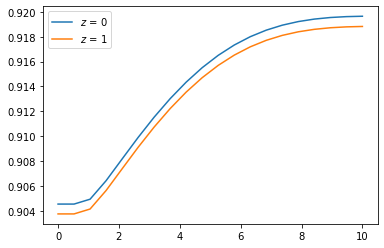

In [404]:
for z in [0, 1]:
    plt.plot(ifp.a_grid, c[:, z], label=f"$z$ = {z}")

plt.legend()
plt.show()

## Testing the assumptions

In [324]:
def G_φ(Z_φ, P_φ):
    
    D_φ = np.diag(Z_φ)
    if D_φ.max() == np.inf:
        G_R = np.nan
    else:
        L_φ = P_φ @ D_φ # 3
        G_φ = max(np.abs(eig(L_φ)[0])) # G_φ = r(L_φ)
    
    return G_φ

In [405]:
G_βR = G_φ(np.exp(ifp.z_vec + (ifp.z_vec)**2 /2), ifp.P)
G_βR

1.0410393036187355